In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import pandas as pd
from pytz import utc
import os
import mlflow
import numpy as np
import matplotlib.pyplot as plt

# mlflow imports
from mlflow.models.signature import infer_signature

# sklearn imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# oma_tracking imports
from oma_tracking.data.utils import read_simulations_csv_files
from oma_tracking.data import make_dataset
from oma_tracking.data.preprocessing import AngleTransformer, sin_cos_angle_inputs
import oma_tracking.models.mlflow_functions as mlflow_f
from oma_tracking.models.utils import convert_dict

from dotenv import load_dotenv
load_dotenv()

# data selection imports
from xgboost import XGBRegressor
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta
from hyperopt import Trials
from hyperopt import hp

import warnings
warnings.filterwarnings('ignore')

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_

In [20]:
start =  datetime.datetime(2022,10,1,tzinfo=utc)
stop  = datetime.datetime(2023,7,4,tzinfo=utc)
location = 'nw2c02'
name_location = 'NW2C02'

# Data Paths
data_root = "../../../"
data_path = data_root + "data/nw2/raw/" + location + "_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
mvbc_path = data_root + "data/nw2/mvbc_data.parquet"
SS1_path = data_root + "data/nw2/tracked_modes/SS1_" + name_location  + ".parquet"
SS2_path = data_root + "data/nw2/tracked_modes/SS2_" + name_location  + ".parquet"

# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
SS1_tracked = pd.read_parquet(SS1_path)
SS2_tracked = pd.read_parquet(SS2_path)

SS1_sorted = SS1_tracked.sort_values(['timestamp', 'size'])
SS1_sorted[SS1_sorted.index.duplicated(keep='last')]
SS1_drop_duplicates = SS1_sorted[~SS1_sorted.index.duplicated(keep='last')]

SS2_sorted = SS2_tracked.sort_values(['timestamp', 'size'])
SS2_sorted[SS2_sorted.index.duplicated(keep='last')]
SS2_drop_duplicates = SS2_sorted[~SS2_sorted.index.duplicated(keep='last')]

SS1_frequency = SS1_drop_duplicates.frequency
SS2_frequency = SS2_drop_duplicates.frequency

scada_inputs = make_dataset.get_scada_subset(data)
weather_data = mvbc_data[mvbc_data.columns[mvbc_data.isna().sum() < len(mvbc_data) * 0.1]]

inputs = \
    pd.concat(
        [
            weather_data,
            scada_inputs
        ],
        axis=1
    )
angle_transformed_inputs = sin_cos_angle_inputs(inputs, angle_type = 'degrees', angles = ['winddirection', 'yaw'])

selected_columns = \
    ['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mean_NW2_C02_rpm',
       'mean_NW2_C02_yaw',
       'mean_NW2_C02_pitch',
       'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed',
       'mean_NW2_C02_winddirection'
    ]
angle_transformed_selected_inputs = sin_cos_angle_inputs(inputs[selected_columns], angle_type = 'degrees', angles = ['winddirection', 'yaw'])

# Verify Shap Values

In [4]:
import xgboost as xgb
import shap

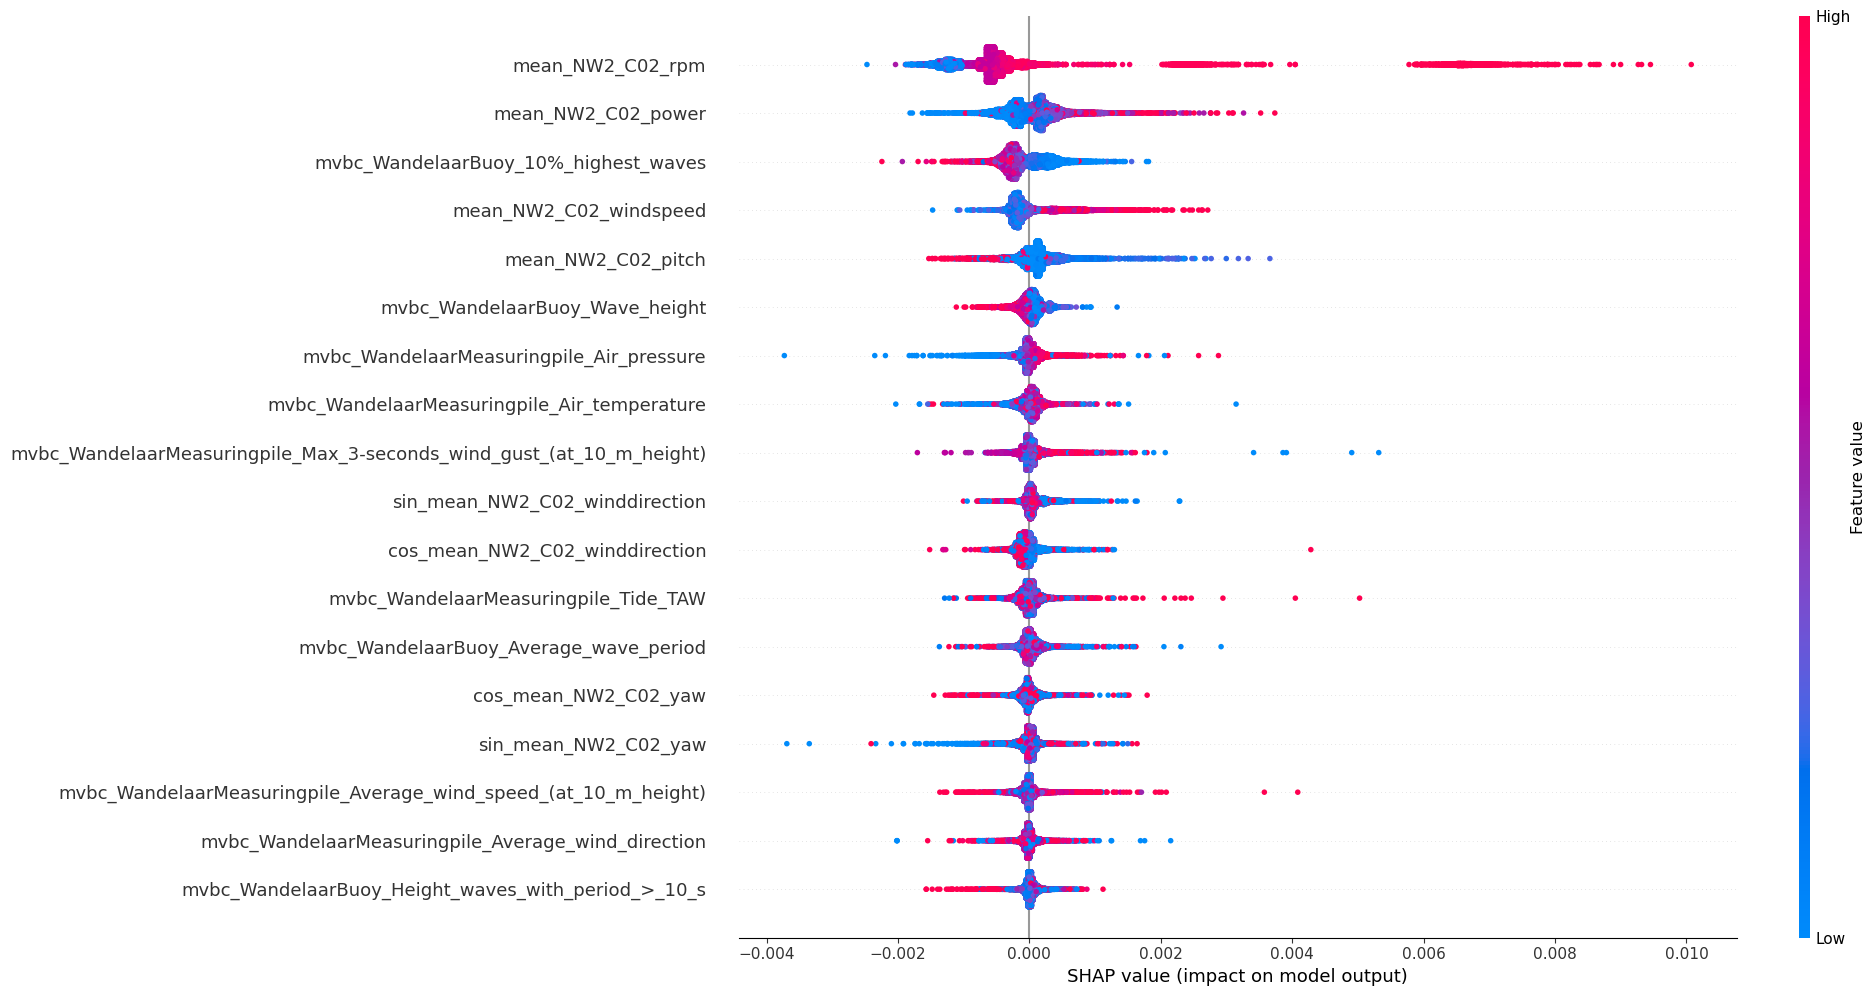

In [21]:
# SS1: All data
y = SS1_frequency.copy().dropna()
X = angle_transformed_inputs.copy().loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor()
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_value = explainer.shap_values(X)
shap.summary_plot(shap_value, X, plot_size=(20, 10))

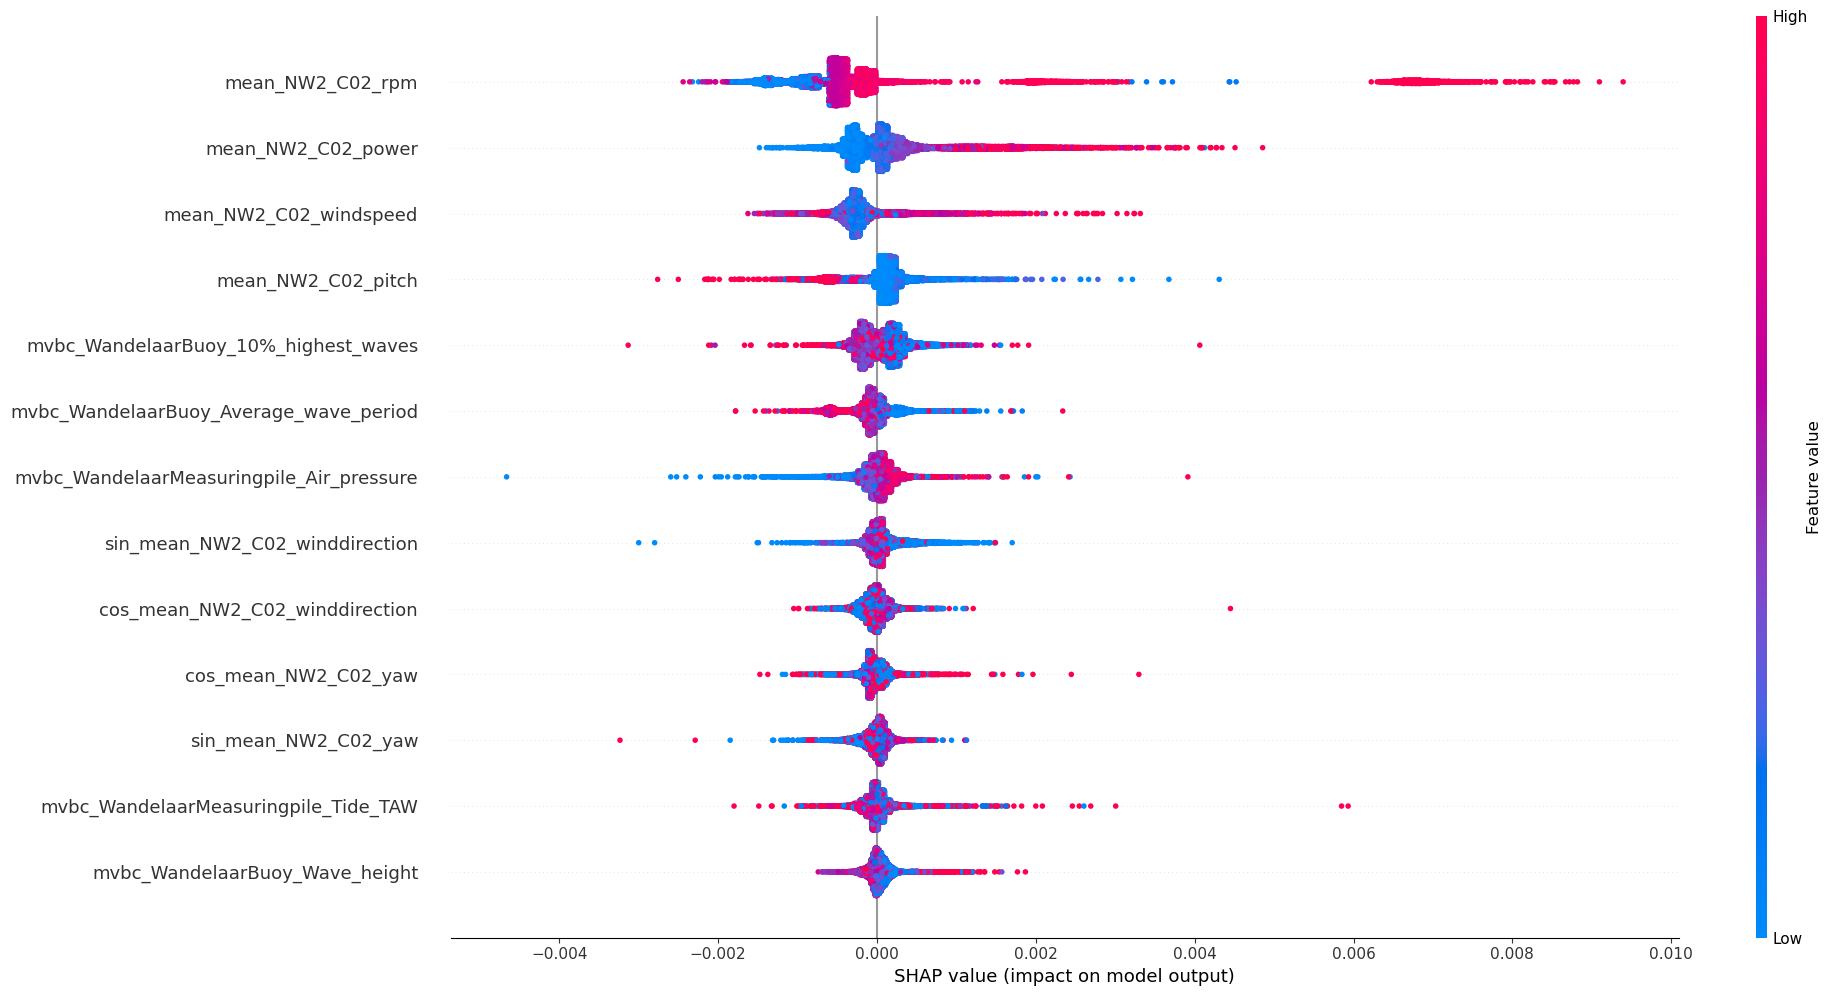

In [27]:
# SS1: Selected data
y = SS1_frequency.copy().dropna()
X = angle_transformed_selected_inputs.copy().loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor()
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_value = explainer.shap_values(X)
shap.summary_plot(shap_value, X,plot_size=(20, 10))

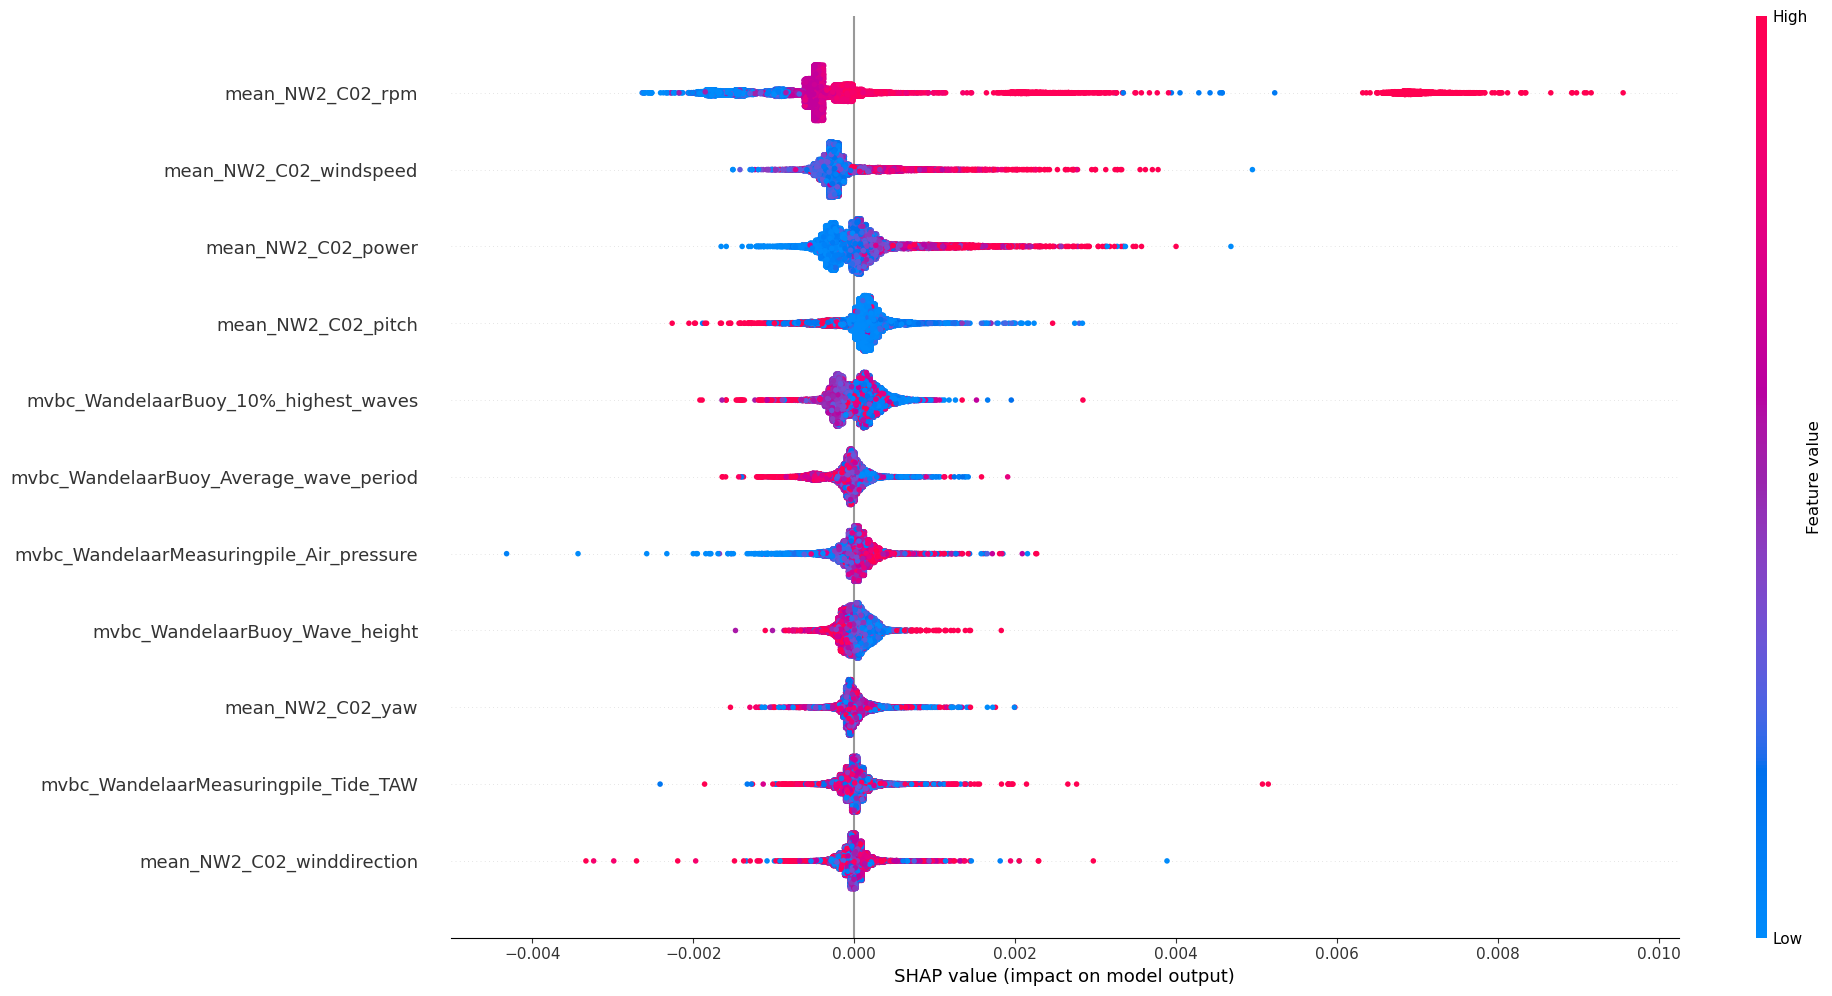

In [25]:
# SS1: Selected data
y = SS1_frequency.copy().dropna()
X = inputs[selected_columns].copy().loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor()
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_value = explainer.shap_values(X)
shap.summary_plot(shap_value, X,plot_size=(20, 10))

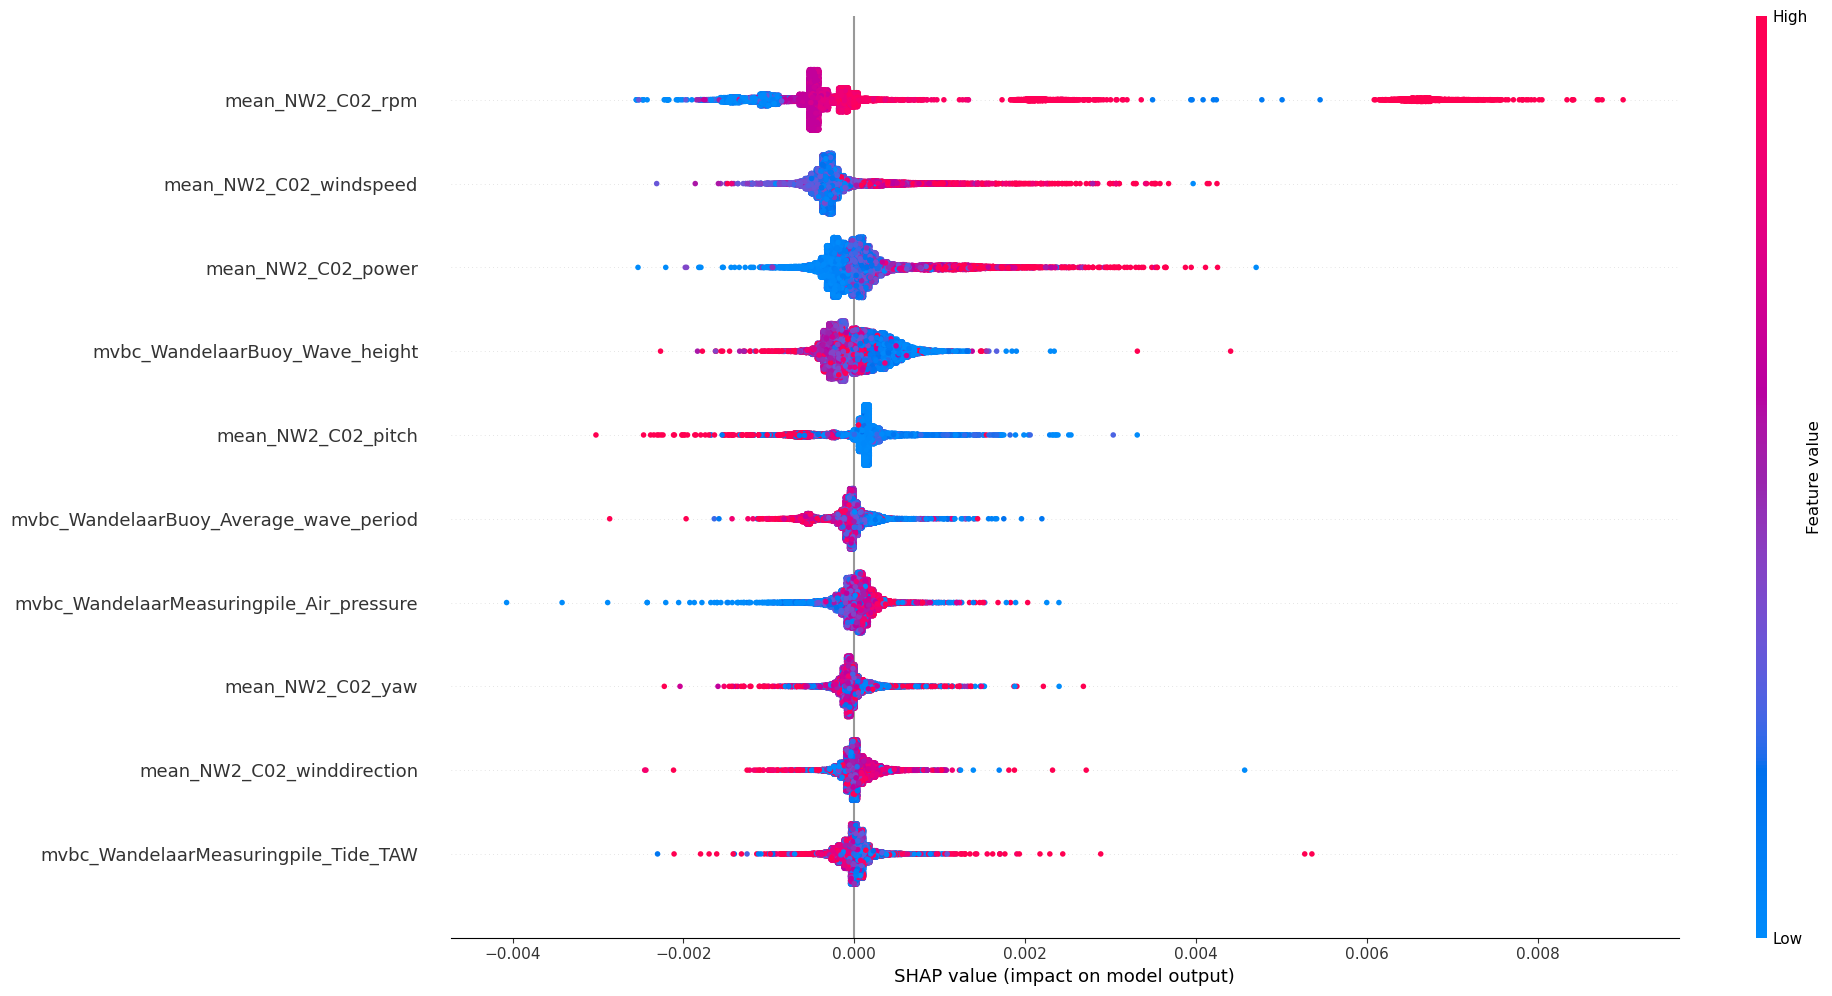

In [26]:
selected_columns = \
    [#'mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mean_NW2_C02_rpm',
       'mean_NW2_C02_yaw',
       'mean_NW2_C02_pitch',
       'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed',
       'mean_NW2_C02_winddirection'
    ]
# SS1: Selected data
y = SS1_frequency.copy().dropna()
X = inputs[selected_columns].copy().loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor()
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_value = explainer.shap_values(X)
shap.summary_plot(shap_value, X,plot_size=(20, 10))

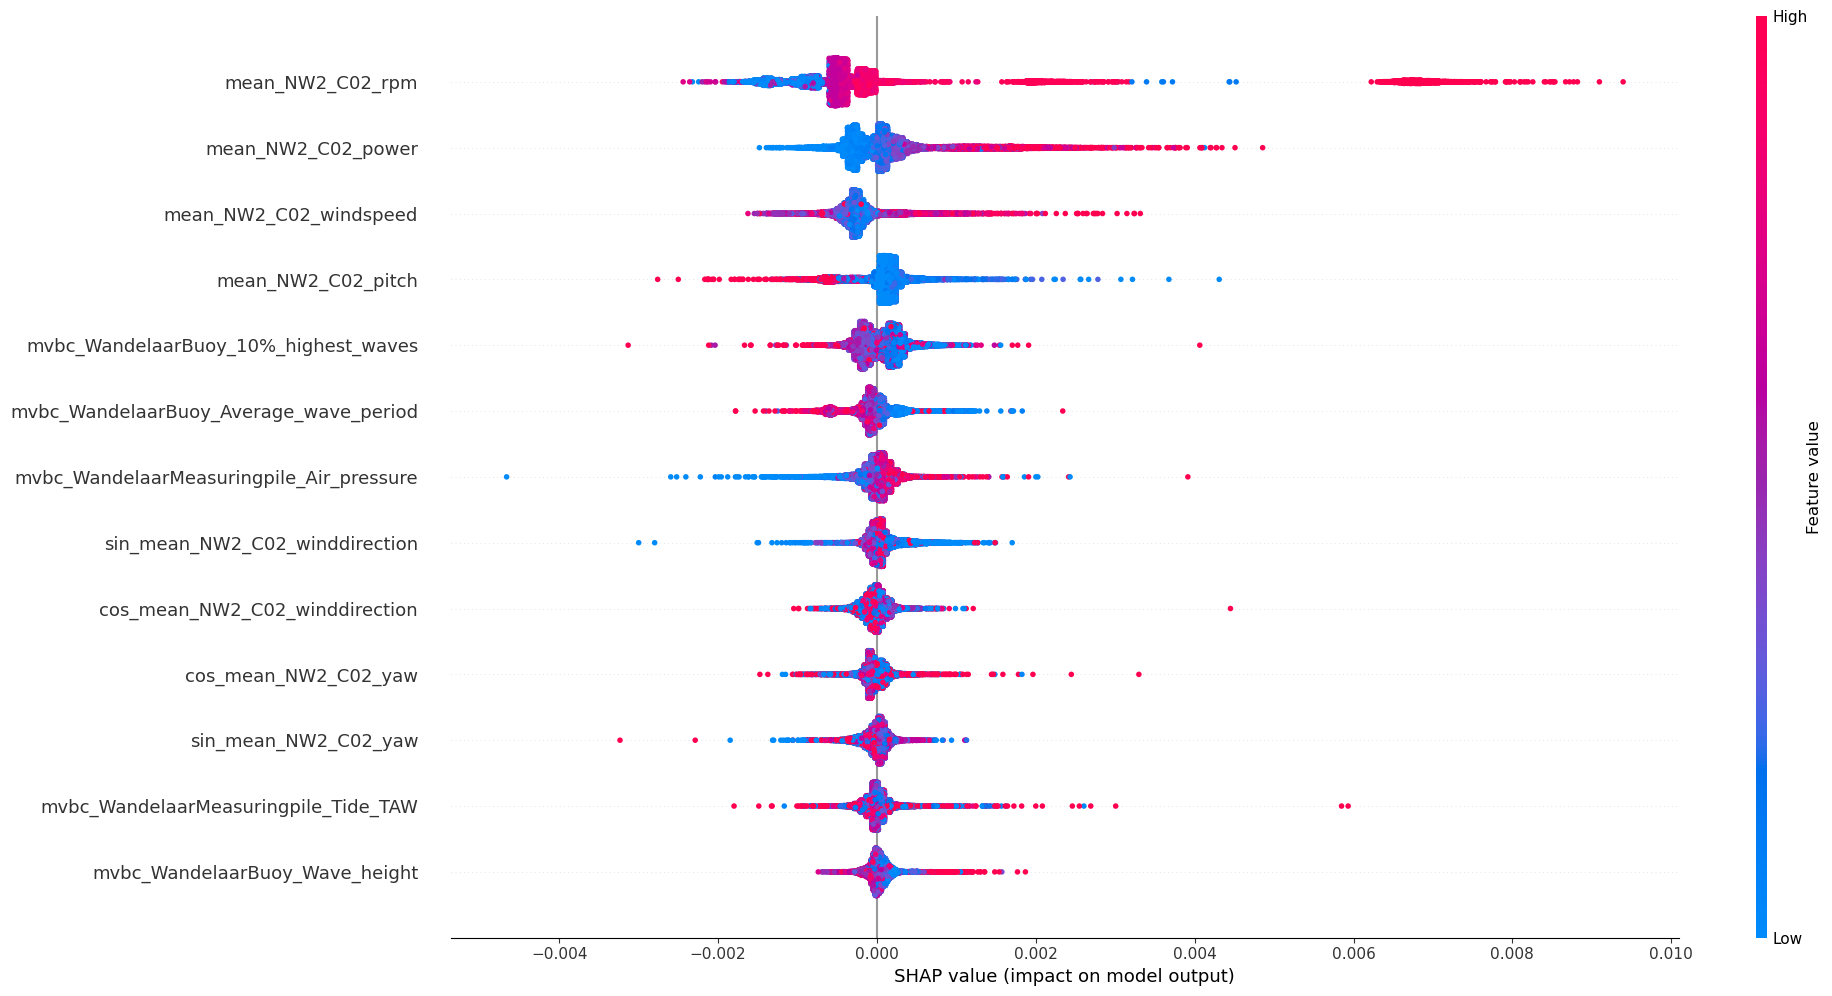

In [24]:
# SS1: Selected data
y = SS1_frequency.copy().dropna()
X = angle_transformed_selected_inputs.copy().loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor()
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_value = explainer.shap_values(X)
shap.summary_plot(shap_value, X,plot_size=(20, 10))

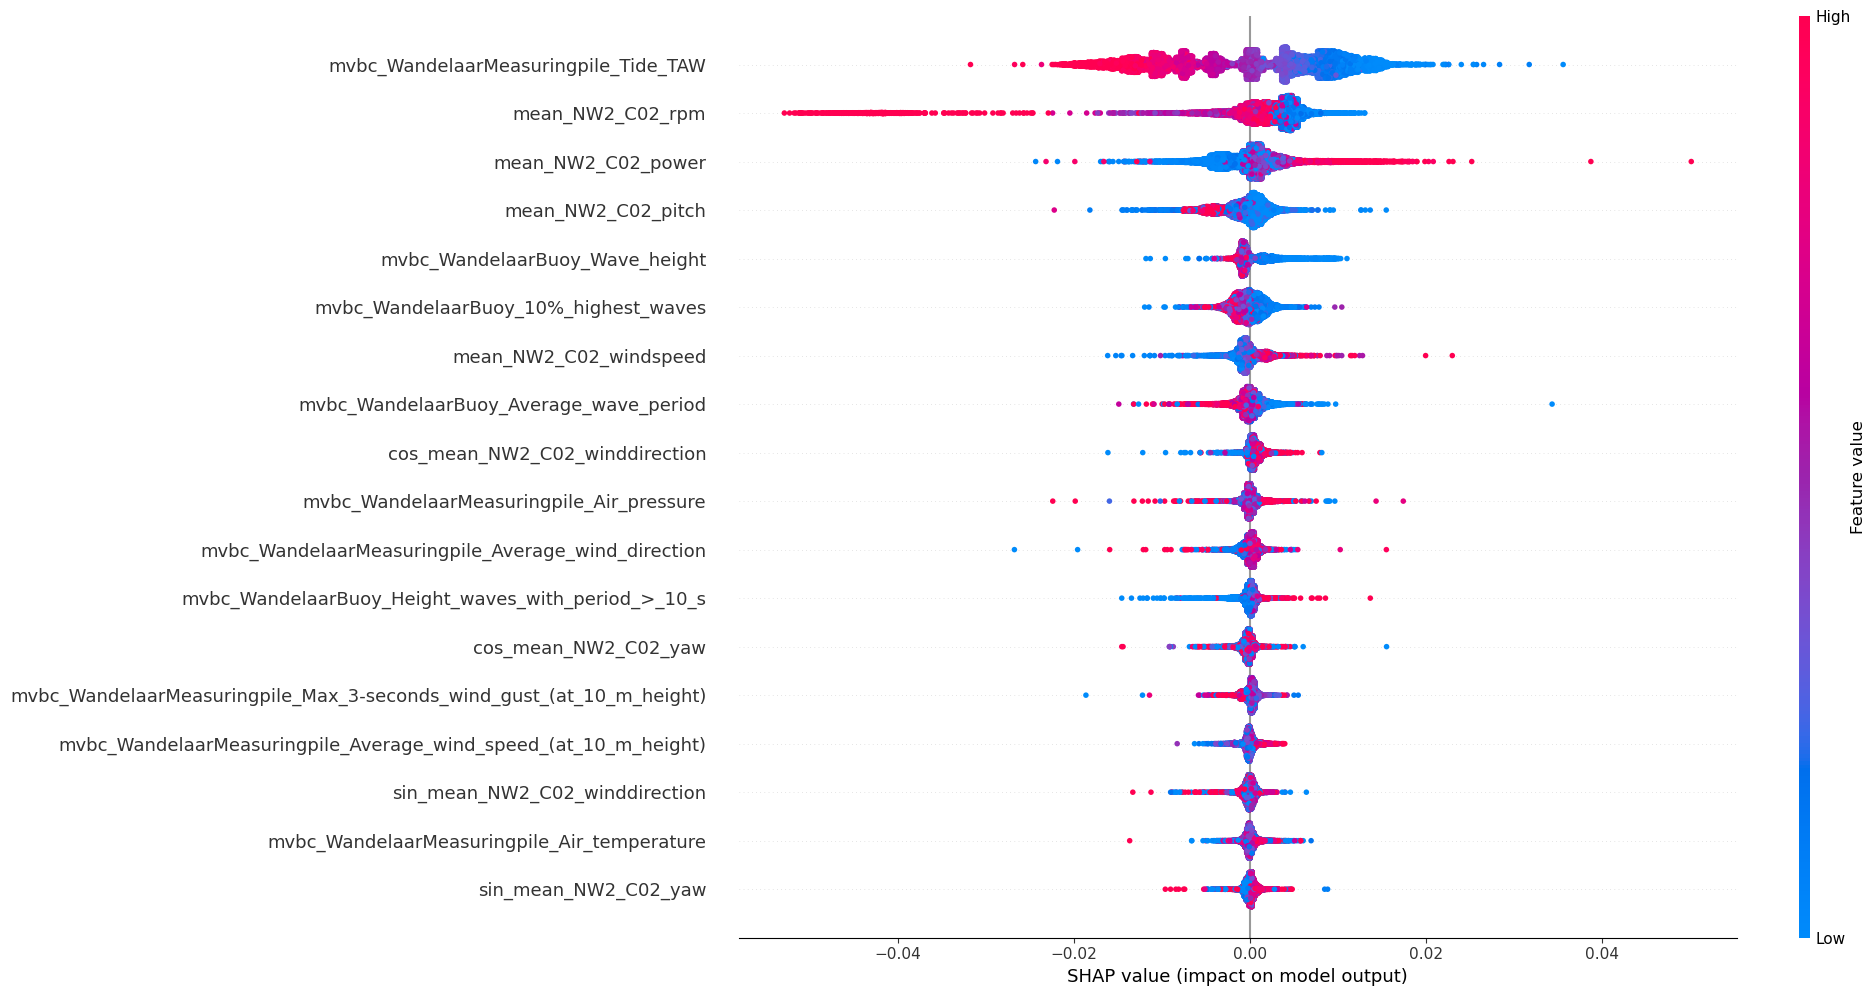

In [18]:
# SS2: All data
y = SS2_frequency.copy().dropna()
X = angle_transformed_inputs.copy().loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor()
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_value = explainer.shap_values(X)
shap.summary_plot(shap_value, X, plot_size=(20, 10))

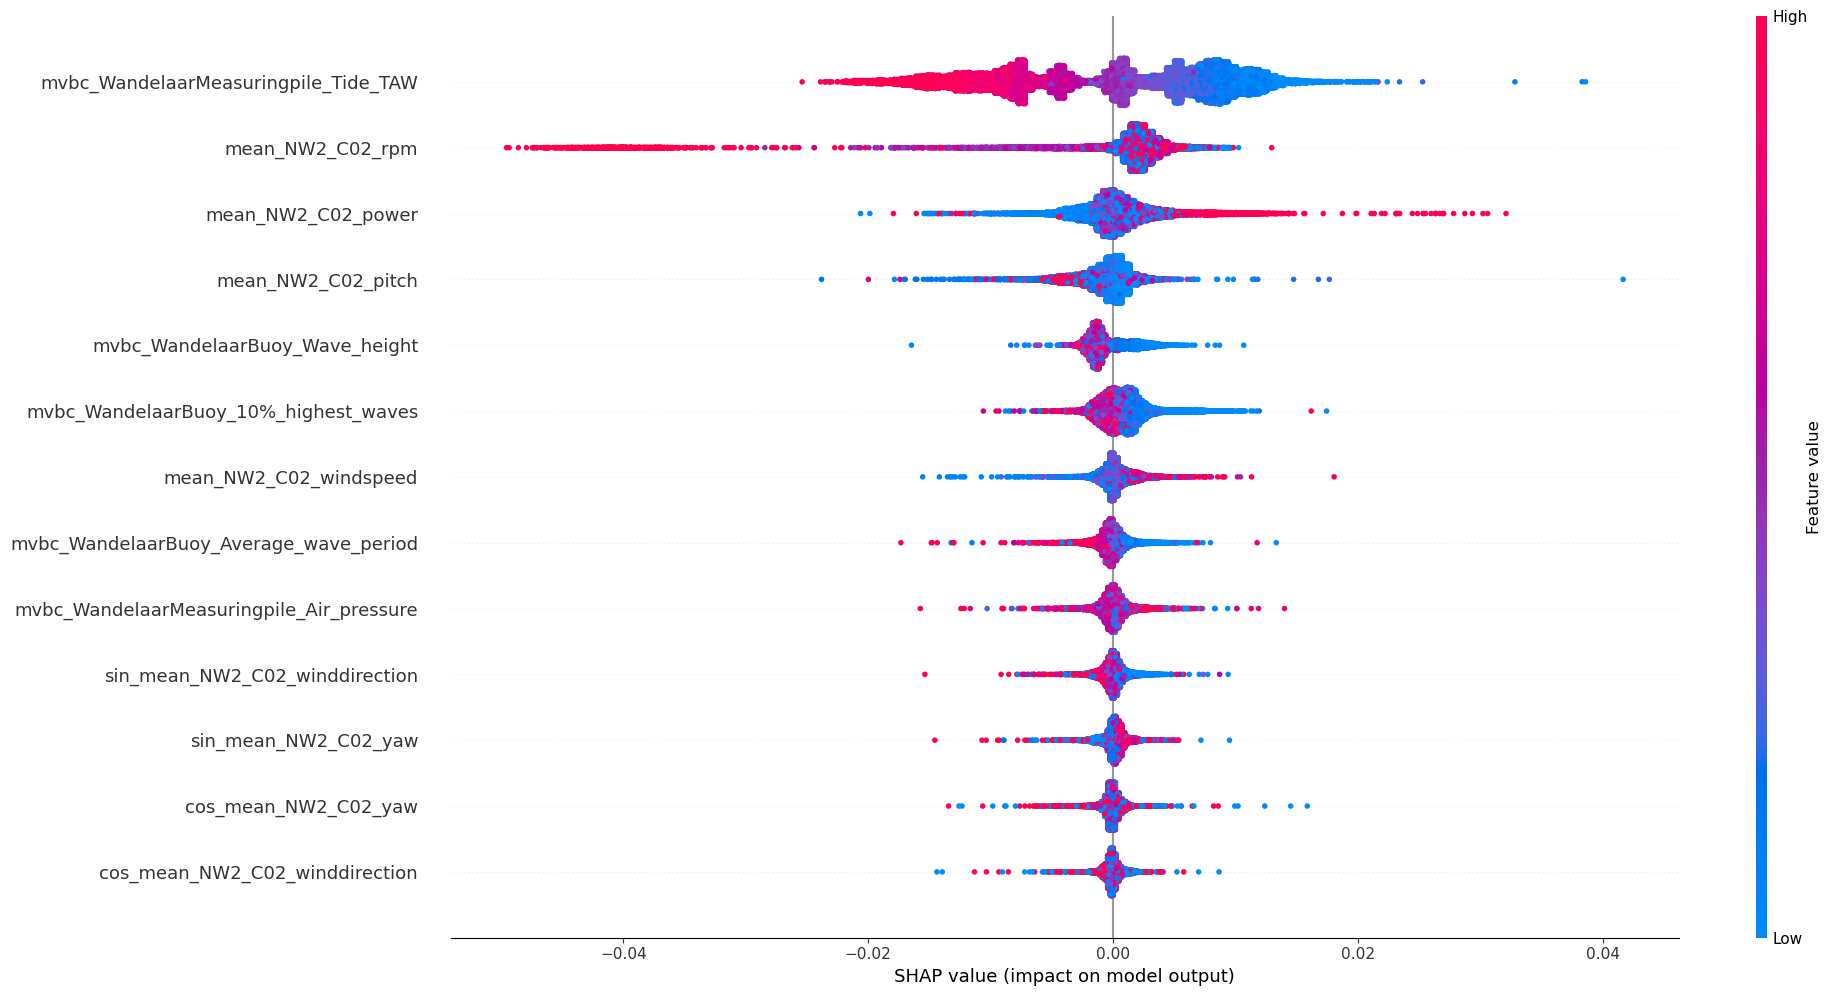

In [23]:
# SS2: Selected data
y = SS2_frequency.copy().dropna()
X = angle_transformed_selected_inputs.copy().loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor()
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_value = explainer.shap_values(X)
shap.summary_plot(shap_value, X, plot_size=(20, 10))